# This is a notebook which describes Amoeba, a code which aims to model Quasar variability modularly.

It is modular in the sense that components may be added or removed and the full model can be built up from pieces. Not all AGN exhibit the same features, and this should be reflected within the model. Please contact Henry Best at HBest@gradcenter.cuny.edu for assistance / bug reports.

At time of writing this notebook, the accretion disk object with lamp post contributions are functional. The inclusion of BLR scattering + contribution is in progress.

Dependencies: Numpy, Astropy, Scipy, Matplotlib, skimage


For running GR ray tracing: Sim5

In [1]:
import numpy as np
import numpy.random as random
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.nddata import block_reduce
from scipy import signal
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import sys
sys.path.append("")   #append path to where QMF and Amoeba files are stored
plt.style.use("plot_style_large_font.txt")
import QuasarModelFunctions as QMF
import Amoeba

We will go down the list on the file QuasarModelFunctions, which hosts a majority of the code. First we will look at the dependence spin has on the ISCO, the innermost stable circular orbit within the Kerr metric.

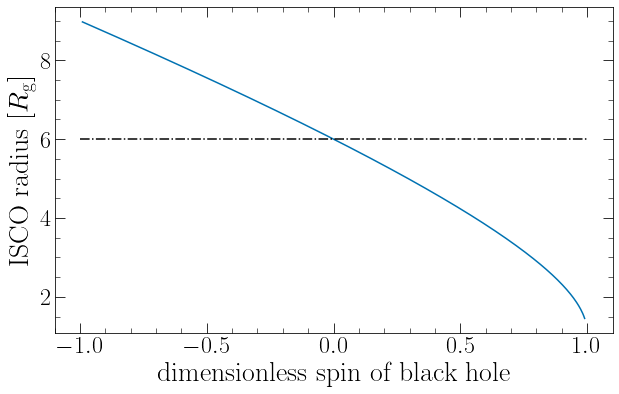

In [2]:
spins = np.linspace(-0.99, 0.99, 500)
r_isco = QMF.SpinToISCO(spins)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(spins, r_isco)
ax.set_xlabel("dimensionless spin of black hole")
ax.set_ylabel(r"ISCO radius [$R_{\rm g}$]")
ax.plot([-1, 1], [6,6], '-.', color='black')
plt.show()

The horizontal line represents the Schwarzschild case for a spinless black hole. Negative values of spin represent a black hole with angular momentum in the opposite direction with respect to the accreted material, while positive values of spin represent alligned angular momentum

Next is the convenience function "EddingtonRatioToMDot", which calculates the accreted material in physical units under the assumption of a specified Eddington ratio with respect to the Eddington luminosity.

The Eddington luminosity is the theoretical limit which balances out gravitational pull against radiation pressure assuming protons are infalling via Bondi accretion. It creates a convenient metric to describe accretion, but this is not a true limit. 

In [3]:
BHmass = 10 ** 8.0 * const.M_sun.to(u.kg)
eddingtons = 0.15
accreted_material = QMF.EddingtonRatioToMDot(BHmass, eddingtons)
print("Black hole mass = ", BHmass)
print("Eddington ratio = ", eddingtons)
print("Accreted material = ", accreted_material)
print("or alternatively,", (accreted_material/const.M_sun.to(u.kg)*u.yr.to(u.s)).value, "M_sun / year")

Black hole mass =  1.988409870698051e+38 kg
Eddington ratio =  0.15
Accreted material =  2.098010464229376e+22 kg / s
or alternatively, 0.33297046047514295 M_sun / year


We see that about 1/3rd of a solar mass is required to be accreted per year to power the accretion disk at 15% of the Eddington limit for a $10^{8}$ solar mass black hole.

Radial temperature profiles can be constructed using the "AccDiskTemp" function. The basic temperature profile is the Shakura-Sunyaev thin disk profile (Shakura+Sunyaev, 1973), and the function provided allows us to smoothly transition to both irradiated disk models (Cackett+ 2007) and disk wind models (Sun+ 2018). By default, a thin disk profile will be constructed. There are a few terms here, so I will outline them now.

R is the position at which we are evaluating the temperature, regardless of the model.

R_min is the inner bound of the accretion disk, usually taken to be the ISCO.

M is the mass of the central black hole.

M_acc is the accreted mass through the accretion disk.

Each of these terms are always required, and are assumed in MKS units.

Terms for the irradiated disk model are:

coronaheight, the height of the central lamp post irradiating the accretion disk. This is assumed to be input in gravitational radii.

albedo, the reflectivity of the accretion disk with respect to irradiating x-ray sources. This is a dimensionless value between 0 and 1, where 0 is perfect absorption (leading to heating up the disk), and 1 is perfect reflection (no heat energy is transfered to the disk).

eta, the efficiency of the x-ray emitter with respect to the Eddington luminosity. This parameter is essentially the Eddington ratio for the corona.

Terms for the disk wind model are:

beta, the strength of the wind. In general, stronger winds are believed to remove material from the accreiton disk causing higher accretion rates further out in the disk than expected. 

genericbeta, a toggle if the user instead wishes to use beta as the asymptotic temperature slope instead of the physically motivated wind parameter.

One last convenience term is "eddingtons", which if given a value, will calculate the required accreted material in order to produce this Eddington ratio.


/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<ipython-input-4-433254595b85>:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(radii), np.log10(thindiskprofile), label="Thin disk")
<ipython-input-4-433254595b85>:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(radii), np.log10(sample_irr_disk), label="Irradiated disk")
<ipython-input-4-433254595b85>:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(radii), np.log10(sample_diskwind), label="Disk wind")


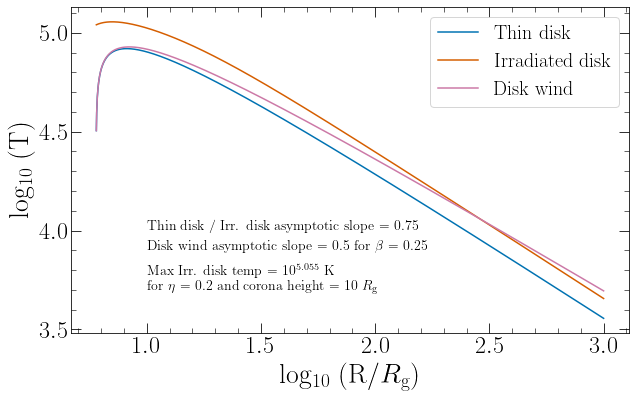

In [4]:
grav_rad = QMF.CalcRg(BHmass)
radii = np.linspace(1, 1000, 50000)
ISCO = 6 * grav_rad
beta = 0.25
lamp_height = 10
eta = 0.2

thindiskprofile = QMF.AccDiskTemp(radii*grav_rad, ISCO, BHmass, 982374598237, eddingtons=0.15)
sample_irr_disk = QMF.AccDiskTemp(radii*grav_rad, ISCO, BHmass, 982374598237, 
                                  coronaheight=lamp_height, albedo=0, eta=eta, eddingtons=0.15)
sample_diskwind = QMF.AccDiskTemp(radii*grav_rad, ISCO, BHmass, 982374598237, 
                                  beta=beta, eddingtons=0.15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log10(radii), np.log10(thindiskprofile), label="Thin disk")
ax.plot(np.log10(radii), np.log10(sample_irr_disk), label="Irradiated disk")
ax.plot(np.log10(radii), np.log10(sample_diskwind), label="Disk wind")
ax.set_xlabel(r"log$_{10}$ (R/$R_{\rm g}$)")
ax.set_ylabel(r"log$_{10}$ (T)")
ax.text(1, 4, "Thin disk / Irr. disk asymptotic slope = 0.75", fontsize=14)
ax.text(1, 3.9, r"Disk wind asymptotic slope = "+str((3 - 4 * beta)/4)+r" for $\beta$ = "+str(beta), fontsize=14)
ax.text(1, 3.7, r"Max Irr. disk temp = 10$^{"+str(np.log10(np.max((sample_irr_disk))))[:5]+r"}$ K"+"\n"+r" for $\eta$ = "+str(eta)+ " and corona height = "+ str(lamp_height) +r" $R_{\rm g}$", fontsize=14)

plt.legend()
plt.show()

Due to the amount of parameters, this profile is quite flexible. The calculation is vectorized leading to rapid calculations even for many points.

The connection between temperature and luminosity is assumed to be black body radiation, given through the Planck formula. The function "PlanckLaw" takes two inputs, a temperature in Kelvins, and a wavelength which is assumed to be in nanometers. This choice was made as it's convenient for UV, optical, and IR emissions, where the accretion disk tends to dominate the quasar's power.

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


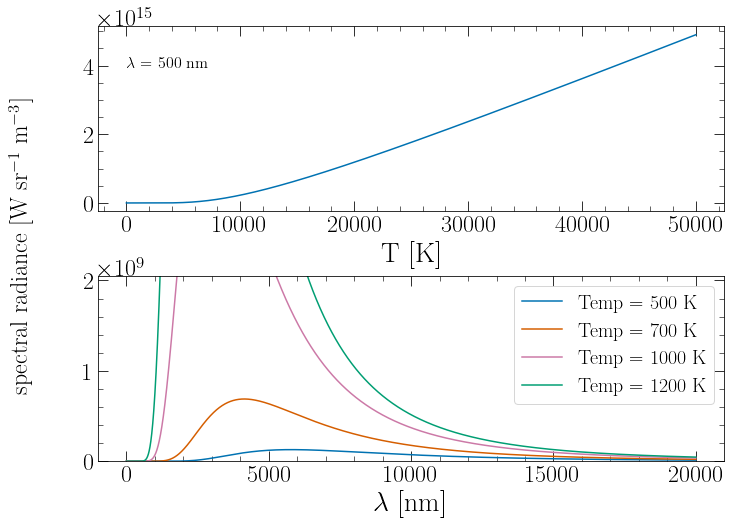

In [5]:
const_lam = 500
const_temp = 1200
maxlam = 20000

temperatures = np.linspace(1, 50000, int(1e6))
wavelengths = np.linspace(1, maxlam, int(1e6))
brightnesses = QMF.PlanckLaw(temperatures, const_lam)
spectra500 = QMF.PlanckLaw(500, wavelengths)
spectra700 = QMF.PlanckLaw(700, wavelengths)
spectra1000 = QMF.PlanckLaw(1000, wavelengths)
spectraconst = QMF.PlanckLaw(const_temp, wavelengths)

fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(temperatures, brightnesses)
ax[1].plot(wavelengths, spectra500, label='Temp = 500 K')
ax[1].plot(wavelengths, spectra700, label='Temp = 700 K')
ax[1].plot(wavelengths, spectra1000, label='Temp = 1000 K')
ax[1].plot(wavelengths, spectraconst, label='Temp = '+str(const_temp)+' K')
ax[1].set_ylim(0, np.max(spectra1000)/2)

ax[0].set_xlabel("T [K]")
ax[1].set_xlabel(r"$\lambda$ [nm]")
ax[0].text(0, 0.8*np.max(brightnesses), r"$\lambda$ = "+str(const_lam)+" nm", fontsize=16)
#ax[1].text(0.5*maxlam, 0.8*np.max(spectra1000), "Constant temp = "+str(const_temp)+" K", fontsize=16)
ax[1].legend()
fig.supylabel("spectral radiance [W sr$^{-1}$ m$^{-3}$]", fontsize=24)
plt.subplots_adjust(hspace=0.35, right=0.85)
plt.show()

Note that these axes are on large scales, due to the radiance being calculated in MKS units. This is a flux density that passes through some solid angle. True fluxes will appear smaller as these are expressed per meter, as opposed to per nanometer or angstrom.

Planck's law will usually be applied to the accretion disk temperature profile, so we can combine the two to create a radial surface birghtness profile.

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


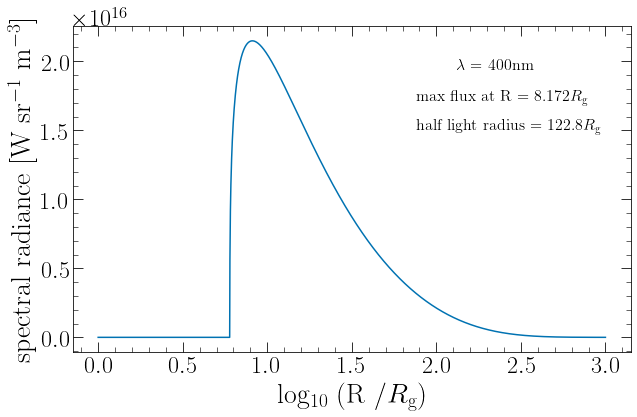

In [6]:
sim_wavelength = 400 #nm
temp_profile = thindiskprofile
sb_profile = QMF.PlanckLaw(temp_profile, sim_wavelength)
half_rad = np.sum(radii*sb_profile) / 2
for kk in range(len(radii)):
    if np.sum(radii[:kk]*sb_profile[:kk]) > half_rad:
        index = kk
        break

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(radii), sb_profile)
ax.text(0.45*np.log10(len(radii)), 0.9*np.max(sb_profile), r"$\lambda$ = "+str(sim_wavelength)+r"nm", fontsize=16)
ax.text(0.4*np.log10(len(radii)), 0.8*np.max(sb_profile), r"max flux at R = "+str(radii[np.argmax(sb_profile)])[:5]+r"$R_{\rm g}$", fontsize=16)
ax.text(0.4*np.log10(len(radii)), 0.7*np.max(sb_profile), r"half light radius = "+str(radii[index])[:5]+r"$R_{\rm g}$", fontsize=16)
ax.set_xlabel(r"log$_{10}$ (R /$R_{\rm g}$)")
ax.set_ylabel("spectral radiance [W sr$^{-1}$ m$^{-3}$]")
plt.show()


The peak flux density will always peak at the point of maximum temperature, but the half light radius will depend on the wavelength evaluated at.

A value which is important for calculating the response of the disk by some external stimulus is the derivative of Planck's law. It is numerically calculated in the approximation that temperature is increased by 1 Kelvin, which is almost always a safe approximation for the effective temperatures of the accretion disk.

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


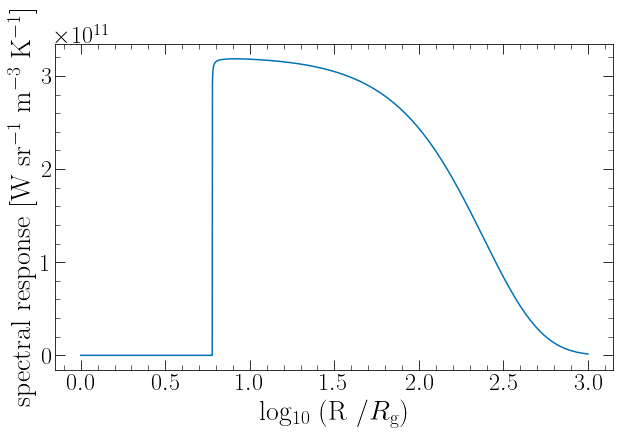

In [7]:
sim_wavelength = 400 #nm
temp_profile = thindiskprofile
sb_profile = QMF.PlanckDerivative(temp_profile, sim_wavelength)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(radii), sb_profile)
ax.set_xlabel(r"log$_{10}$ (R /$R_{\rm g}$)")
ax.set_ylabel("spectral response [W sr$^{-1}$ m$^{-3}$ K$^{-1}$]")
plt.show()

It is immediately apparent that this curve is wider for accretion disks than the spectral radiance, and will lead to the structure of response functions later in this notebook.

A few functions for calculating distances in flat cosmology are included, such as angular diameter distance, angular diameter distance difference, and luminosity distance. One classic example is the turnover for angular diameter distance.

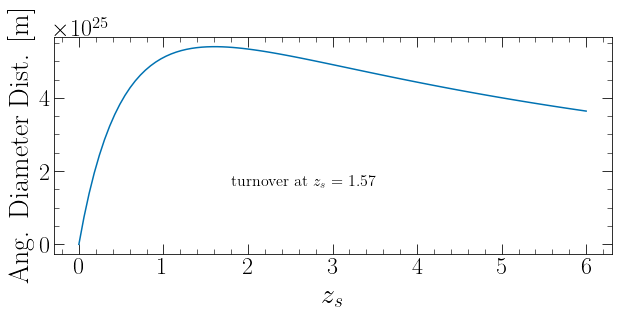

In [8]:
Omega_0 = 0.3 # mass percentage of universe
Omega_lam = 0.7 # energy percentage of universe
little_h = 0.7 # H0 / (100 km/s/Mpc)

redshifts = np.linspace(0, 6, 100)
ang_diameters = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    ang_diameters[rs] = QMF.CalcAngDiamDist(redshifts[rs], Om0 = Omega_0, OmL = Omega_lam, little_h = little_h).value

    
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(redshifts, ang_diameters)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("Ang. Diameter Dist. [m]")
ax.text(0.3*np.max(redshifts), 0.3*np.max(ang_diameters), r"turnover at $z_{s}$ = "+str(redshifts[np.argmax(ang_diameters)])[:4], fontsize=16)
plt.show()
        

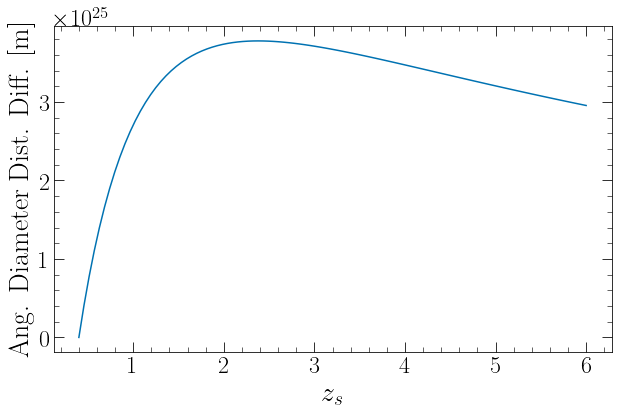

In [9]:
Omega_0 = 0.3 # mass percentage of universe
Omega_lam = 0.7 # energy percentage of universe
little_h = 0.7 # H0 / (100 km/s/Mpc)
z1 = 0.4

redshifts = np.linspace(z1, 6, 100)
ang_dia_diffs = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    ang_dia_diffs[rs] = QMF.CalcAngDiamDistDiff(z1, redshifts[rs], Om0 = Omega_0, OmL = Omega_lam, little_h = little_h).value

    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(redshifts, ang_dia_diffs)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("Ang. Diameter Dist. Diff. [m]")
plt.show()

Luminosity distances can be used to scale emission simulations to cosmological distances

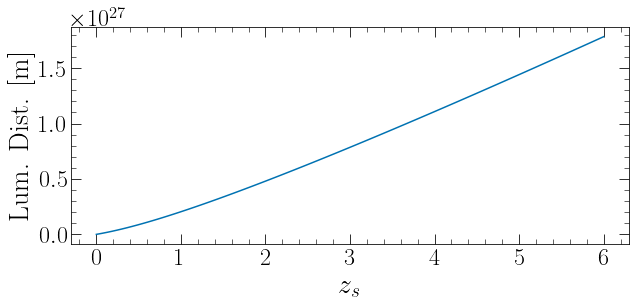

In [10]:
Omega_0 = 0.3 # mass percentage of universe
Omega_lam = 0.7 # energy percentage of universe
little_h = 0.7 # H0 / (100 km/s/Mpc)

redshifts = np.linspace(0, 6, 100)
lum_dist = np.zeros(np.shape(redshifts))
for rs in range(len(redshifts)):
    lum_dist[rs] = QMF.CalcLumDist(redshifts[rs], Om0 = Omega_0, OmL = Omega_lam, little_h = little_h).value

    
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(redshifts, lum_dist)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel("Lum. Dist. [m]")
plt.show()

Unlike diameter distances, the luminosity distance does not have a turnover point.

An important quantity in microlensing is the Einstein radius, which depends on the lens and source positions. Cosmology also effects this as the angular diameter distances are used.

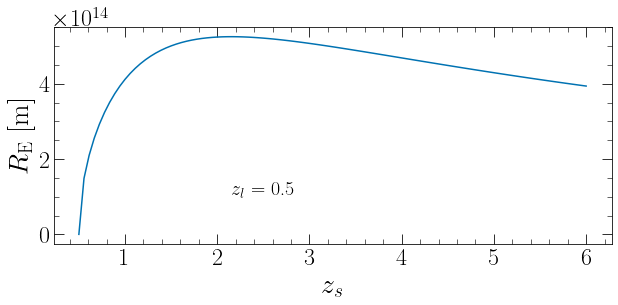

In [11]:
z_lens = 0.5
z_s = np.linspace(z_lens, 6, 100)
m_lens = const.M_sun.to(u.kg)

ein_rad = np.zeros(np.shape(z_s))
for rs in range(len(z_s)):
    ein_rad[rs] = QMF.CalcRe(z_lens, z_s[rs], M_lens=m_lens) * QMF.CalcAngDiamDist(z_s[rs]).value

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(z_s, ein_rad)
ax.set_xlabel(r"$z_{s}$")
ax.set_ylabel(r"$R_{\rm E}$ [m]")
ax.text(0.3 * (np.max(z_s)-np.min(z_s)) + np.min(z_s), 0.2 * np.max(ein_rad), r"$z_{l}$ = "+str(z_lens), fontsize=20)
plt.show()
                

Like with other angular diameter distances, this experiences a turnover as well. The Einstein radius determines the scale which microlensing probes most effectively at. 

We do not provide magnification maps in the source plane, so this must be obtained elsewhere through inverse ray shooting methods or other similar procedures. With the representative map of magnifications, we can explore the convolution between an accretion disk surface brightness image and the magnifications due to microlensing

Set up a generic surface brightness map

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:166: RuntimeWarning: divide by zero encountered in true_divide
  tempmap = ( ( (3.0 * G * M * m0_dot * (1.0 - ((r_in) / r)**(0.5))) / (8.0 * pi * sigma * Rs**3) )**(0.25)).decompose().value * (r**(-(3-beta)/4))
/usr/local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:166: RuntimeWarning: divide by zero encountered in power
  tempmap = ( ( (3.0 * G * M * m0_dot * (1.0 - ((r_in) / r)**(0.5))) / (8.0 * pi * sigma * Rs**3) )**(0.25)).decompose().value * (r**(-(3-beta)/4))
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:172: RuntimeWarning: invalid value encountered in multiply
  temp = (visc_temp**4 + geometric_term * Lx)**(1/4) * zeroes
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero en

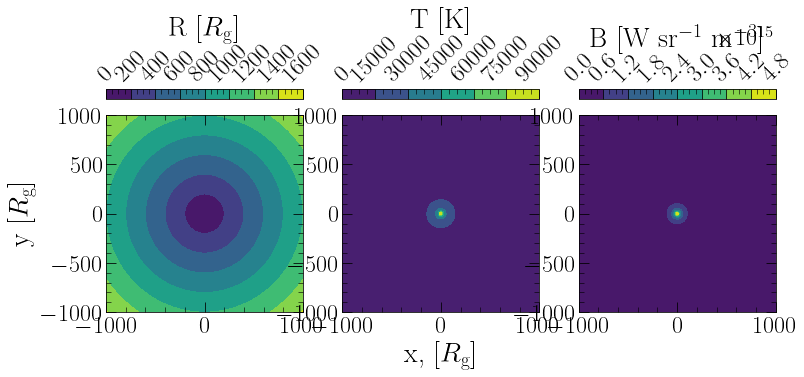

In [12]:
x = np.linspace(-1000, 1000, 2001)
y = np.linspace(-1000, 1000, 2001)
X, Y = np.meshgrid(x, y)
radii = (X**2 + Y**2)**0.5
mass = 10**8.0*const.M_sun.to(u.kg)
grav_rad = QMF.CalcRg(mass)
temp_map = QMF.AccDiskTemp(radii*grav_rad, 6*grav_rad, mass, 7234, eddingtons=0.15)
sb_map = QMF.PlanckLaw(temp_map, 600)

fig, ax = plt.subplots(1,3,figsize=(12, 6))
c1 = ax[0].contourf(X, Y, radii)
c2 = ax[1].contourf(X, Y, temp_map)
c3 = ax[2].contourf(X, Y, sb_map)
cbar1 = plt.colorbar(c1, ax=ax[0], location='top', label=r'R [$R_{\rm g}$]')
cbar2 = plt.colorbar(c2, ax=ax[1], location='top', label='T [K]')
cbar3 = plt.colorbar(c3, ax=ax[2], location='top', label=r'B [W sr$^{-1}$ m$^{-3}$]')
cbar1.ax.tick_params(rotation=45)
cbar2.ax.tick_params(rotation=45)
cbar3.ax.tick_params(rotation=45)
ax[0].set_ylabel(r"y [$R_{\rm g}$]")
ax[1].set_xlabel(r"x, [$R_{\rm g}$]")
for axis in ax:
    axis.set_aspect(1)
plt.show()

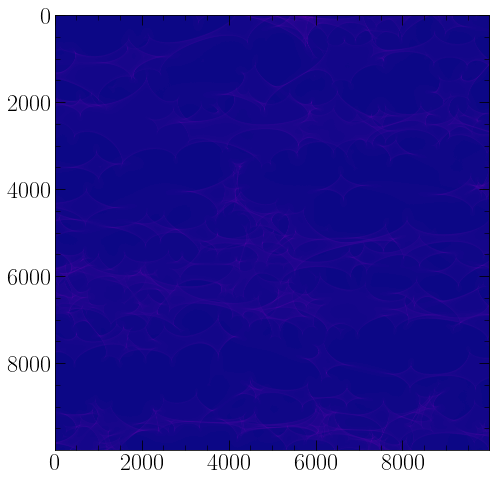

In [13]:
mag_map_path = "Amoeba/SampleMagMap/map.fits"

with fits.open(mag_map_path) as f:
    mag_map = f[0].data

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(mag_map, cmap='plasma')
plt.show()

The funciton "ConvolveMaps" can be used to make the convolution between the magnification map and the surface brightness map. Inputs are as follows:

MagMap is the magnification map

disk is the image of the disk in the source plane

redshift_lens is the redshift of the microlenses 

redshift_source is the redshift of the source

mass_exp is log_10(M_BH/M_sun)

mlens is the microlens mass

nmapERs is the number of Einstein radii the magnification map covers on each side

numGRs is the number of gravitational radii the disk image is

rotation is an angular rotation given to the accretion disk in the source plane, especially interesting for inclined accretion disks (in degrees)

verbose is a toggle to keep track of each step in the process

returnmag2d allows the magnificaiton map to be returned as well

The pixel sizes are :  1311910097103.111 m
The pixel shift due to the convolution is :  112 pixels


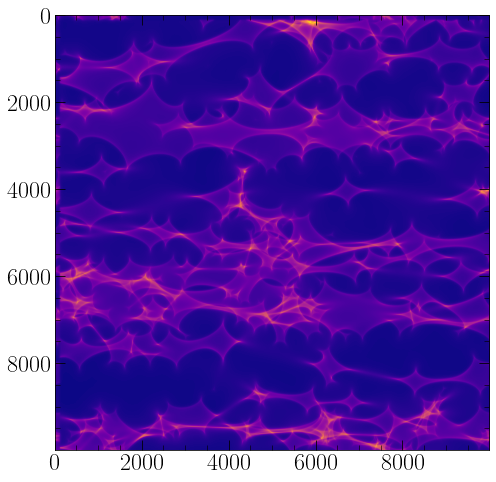

In [14]:
convolution, px_size, px_shift = QMF.ConvolveMaps(mag_map, sb_map, numGRs=2000)

print("The pixel sizes are : ", px_size)
print("The pixel shift due to the convolution is : ", px_shift, "pixels")
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(convolution, cmap='plasma')   
plt.show()

Depending on the size of the accretion disk, there is a region near the edges we must not use to avoid convolution artifacts. 

From this map, we can pull random light curves using PullLC function.

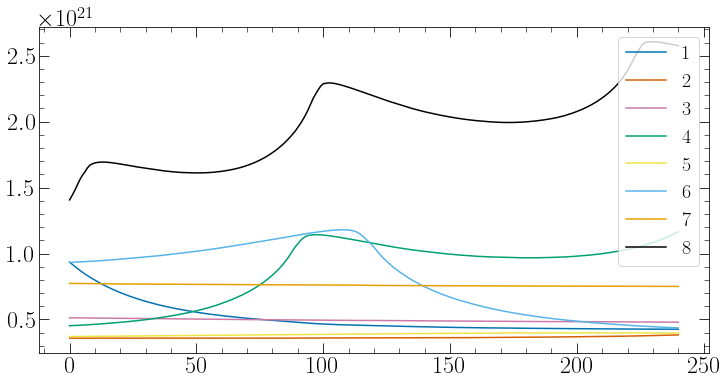

In [15]:
v_trans = 500 # km/s in source plane
time = 20 # years
np.random.seed(20)

LCs = []
tracks = []

for jj in range(8):
    curve, track = QMF.PullLC(convolution, px_size, v_trans, time, px_shift=px_shift, returntrack=True)
    LCs.append(curve)
    tracks.append(track)

fig, ax = plt.subplots(figsize=(12, 6))
for jj in range(len(LCs)):
    ax.plot(LCs[jj], label=str(jj+1))
ax.legend()
plt.show()




To show where these came from, we may plot the tracks on the convolution

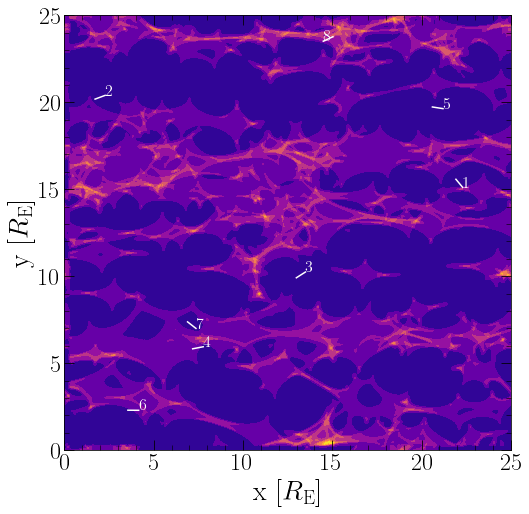

In [16]:
x = np.linspace(0, 25, 10000)  # Convert axes to units R_g
y = np.linspace(0, 25, 10000)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(X, Y, convolution, cmap='plasma')
for jj in range(len(tracks)):
    ax.plot(tracks[jj][1]/400, tracks[jj][0]/400, color='white')
    ax.text(tracks[jj][1][0]/400, tracks[jj][0][0]/400, str(jj+1), color='white', fontsize=16)
ax.set_xlabel(r"x [$R_{\rm E}$]")
ax.set_ylabel(r"y [$R_{\rm E}$]")

plt.show()

For reproducability, a random seed may be set.

Going back to the accretion disk itself, the lamp post model predicts time lags to be dominated by the light travel time between the x-ray source and the accretion disk. This may be extended to any source of additional flux which may heat up the accretion disk, i.e. a magnetic recombination flare in plasma, an unstable jet base, etc. 

The function MakeTimeDelayMap allows for the creation of a time lag map from any point above the accretion disk to the midplane of the accretion disk. Geometries beyond a flat disk cannot be handled by Sim5 which is used for geodesic tracing around the central black hole, but this is a planned area of future work.

The arguments are as follows:

disk is the accretion disk temperature map

inc_ang is the inclination angle

massquasar is the mass of the central black hole

redshift is the source redshift

diskres is the resolution of the disk, if a file is put in as opposed to the disk itself

numGRs is the number of gravitational radii the disk has along an edge

coronaheight is the height of the lamp post (or other flaring driving object) in gravitational radii

axisoffset is the number of gravitational radii off the axis of symmetry where the lamp post / flare occurs

angleoffset is a degree measure which the axisoffset gets rotated (e.g. r, phi coords)

unit determines the time scales measured in

jitters is a term which, if left true, allows for the calculation to any random point in the pixel instead of calculations being grid-spaced. This helps smooth constructed transfer functions. However, this should be set to "False" for the creation of isodelay surfaces.

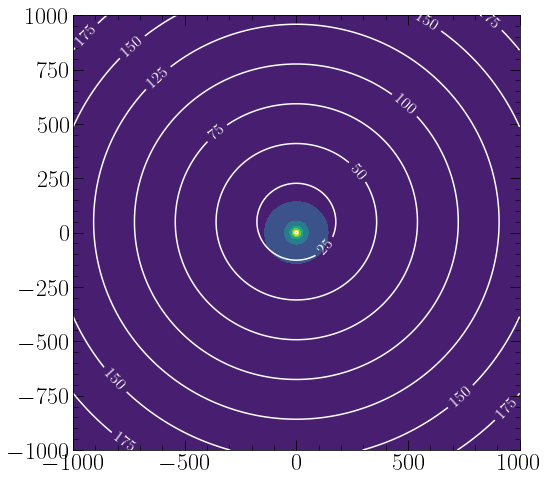

In [17]:
time_delays = QMF.MakeTimeDelayMap(temp_map, 0, redshift=0, numGRs=2000, coronaheight=5, 
                                  axisoffset=50, angleoffset=0, jitters=False)
x = np.linspace(-1000, 1000, 2001)
y = np.linspace(-1000, 1000, 2001)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(X, Y, temp_map)
delays = ax.contour(X, Y, time_delays, colors='white')
plt.clabel(delays, inline=1, fontsize=16)
plt.show()

specifying the redshift is important because all time scales, including these time delays, will get scaled.

ConstructGeometricDiskFactor is a function which calculates the geometric coefficient in the lamp post model. If we assume the same functional form which connects the lamp post to the heating of the disk, this term can be extended to be used with any other flaring event beyond the lamp post model including those described in the time delay map description above.

This function takes the following arguments:

disk is the accretion disk temperature map

inc_ang is the inclination angle with respect to the observer (used for vectorization, but not explicitly used in the calculation of values)

massquasar is the mass of the quasar in kg

coronaheight is the position of the source calculated from on the z axis, in units gravitational radii

axisoffset is the offset of the axis of symmetry in units gravitational radii

angleoffset is the angular rotation of the source position

numGRs is the number of gravitational radii the accretion disk image is

albedo is the reflectivity of the disk, where 0 is perfect absorption and 1 is perfect reflection


<ipython-input-18-a052d2b736e2>:4: RuntimeWarning: divide by zero encountered in log10
  conts = ax.contourf(X, Y, np.log10(disk_factor))


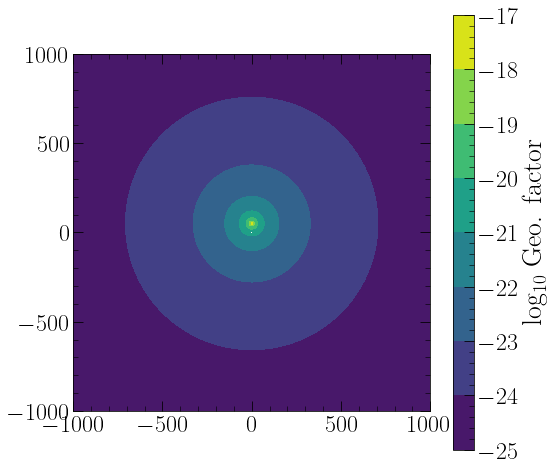

In [18]:
disk_factor = QMF.ConstructGeometricDiskFactor(temp_map, 0, mass, 5, numGRs=2000, 
                                  axisoffset=50, angleoffset=0)
fig, ax = plt.subplots(figsize=(8,8))
conts = ax.contourf(X, Y, np.log10(disk_factor))
cbar = plt.colorbar(conts, ax=ax, label=r"log$_{10}$ Geo. factor")
ax.set_aspect(1)
plt.show()

For the case of the lamp post illuminator, the geometric factor above scales the x-ray luminosity. Under the assumption any other illuminator acts the same way, the geometric factor should remain identical and this can be used at any other position.

The function "MakeDTDLx" calculates the rate of change in temperature with respect to illumination from the x-ray source

its arguments are:

disk_der, the derivative of Planck's law with respect to temperature mapped to the accretion disk. 

temp_map, the map of the temperature of the accretion disk

inc_ang, the inclination angle of the disk

massquasar, the mass of the central black hole

coronaheight, the (z) position of the illuminating object in gravitational radii

axisoffset/angleoffset, the (r, phi) position of the illuminating source in gravitational radii and degrees



/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: overflow encountered in power
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input


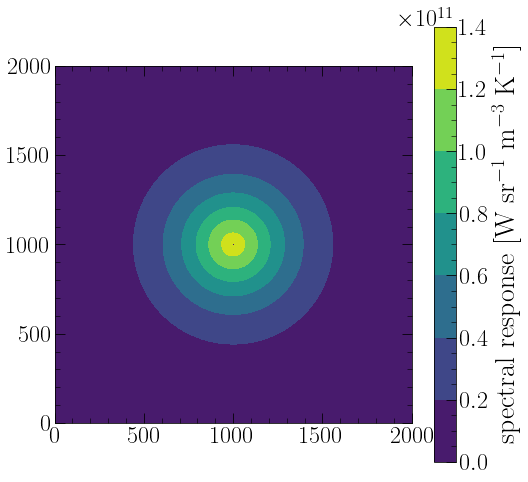

In [19]:
lam = 500
disk_deriv = QMF.PlanckDerivative(temp_map, lam)

fig, ax = plt.subplots(figsize=(8,8))
conts = ax.contourf(disk_deriv)
plt.colorbar(conts, ax=ax, label="spectral response [W sr$^{-1}$ m$^{-3}$ K$^{-1}$]")
ax.set_aspect(1)
plt.show()

These values look high, but the geometric factor hasn't been taken into account yet, nor the power of the illuminating source.

Combining all of the above, we can construct the transfer function which connects the driving source to the accretion disk's response. This is the kernel between some impulse at a position above the disk and the disk's response, and is wavelength dependent.

ConstructDiskTransferFunction has the following arguments:

image_der_f, the derivative of the Planck function with respect to temperature at some wavelength

temp_map, a map of the temperature of the accretion disk

inc_ang, the inclination angle of the disk

massquasar, the mass of the central black hole

redshift, the redshift of the source

coronaheight, the z position of the source in gravitational radii

maxlengthoverride, the maximum time units the transfer function will be calculated out to

units, the units of the time axis of the transfer function

axisoffset/angleoffset, the (r, phi) position of the source with respect to the axis of symmetry

numGRs, the number of gravitational radii the accretion disk image has

albedo, the reflectivity of the accretion disk. 0 is perfect absorption, while 1 is perfect reflection.

smooth, a toggle to apply a smoothing kernel to the transfer function to help remove artifacts from pixelation of the source

fixedwindowlength, an override for the size of the smoothing kernel. If left "None", a size will be determined.

/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:519: RuntimeWarning: invalid value encountered in true_divide
  output = weightingmap/(4*(T_orig)**3)


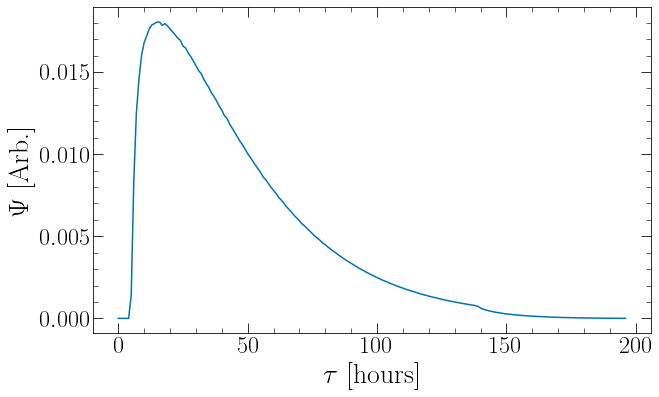

In [20]:
cheight = 20

basic_transfer_function = QMF.ConstructDiskTransferFunction(disk_deriv, temp_map, 0, mass, 0, cheight, smooth=False, numGRs=2000)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(basic_transfer_function)
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel(r"$\Psi$ [Arb.]")
plt.show()

The transfer function generally features an initial time lag, which depends on how far light must travel down to the accretion disk before being reprocessed and coming back to the observer. Then this is followed by a steep rise when the source is on the central axis. It generally trails off slowly, and sometimes may be truncated due to the disk not being calculated to infinity.

Inclined accretion disks tend to have skewed transfer functions, and the midpoint may change if the source height is significantly above the disk. For sources approximately on the same level of the disk, the mean time lag will not be effected by orientation.

The "MicrolensedResponse" function essentially combines the creation of a transfer function with the amplified response due to a static microlensing map. It has the following arguments:

MagMap, the magnification map due to microlensing

AccDisk, an Amoeba accretion disk object (we have not gotten to classes yet, more to come at bottom!)

wavelength, the wavelength which the transfer function will be evaluated at

coronaheight, the z position of the illuminating source

rotation, a rotation in degrees on the source plane. Not important for symmetric accretion disks, but can be impactful for inclined disks.

x_position/y_position, the (x, y) position of the disk on the magnification map

axisoffset/angleoffset, the (r, phi) position of the illuminating source with respect to the axis of symmetry above the accretion disk

unit, the time units for calculating the magnified transfer function

smooth, boolean determining if a smoothing kernel will be used on the transfer function

returnmaps, boolean which toggles the output to be the time delays, response map, and positions on the magnification map for True, or just the transfer function for False.

To show how this is used, we must create an accretion disk object. This class holds everything related to the disk and combines the above functions into something significantly more useful. We will start by creating the ThinDisk object. It is named such simply because it is a flat disk, the temperature profile may arbitrarily differ from the Shakura-Sunyaev disk.

In [21]:
AccretionDisk = Amoeba.ThinDisk(8.0, 0.1, 1000, 0, cheight, temp_map, 
                                np.zeros(np.shape(temp_map)), np.ones(np.shape(temp_map)),
                               radii)
MagMap = Amoeba.MagnificationMap(0.1, 0.05, mag_map, 0.3, 0.3, ismagmap=True)

/Users/henrybest/PythonStuff/Code/Amoeba.py:156: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if file_name[-4:] == 'fits':
/Users/henrybest/PythonStuff/Code/Amoeba.py:159: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif file_name[-4:] == '.dat':


10000
0.004938182452918769
506.25913964
50625913964.0


With this object (which will be described soon), we can look at the MicrolensedResponse function.

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: divide by zero encountered in true_divide
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in power
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:187: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(2.0 * h.value * c.value**2 * (lam)**(-5.0) * ((e**(h.value * c.value / (lam * k.value * T)) - 1.0)**(-1.0)))  # This will return the Planck Law wavelength function at the temperature input
/Users/henrybest/PythonStuff/Cod

0.232096060470936 147588709450.28732 635894935703.8698


/Users/henrybest/PythonStuff/Code/QuasarModelFunctions.py:519: RuntimeWarning: invalid value encountered in true_divide
  output = weightingmap/(4*(T_orig)**3)


0.232096060470936 147588709450.28732 635894935703.8698


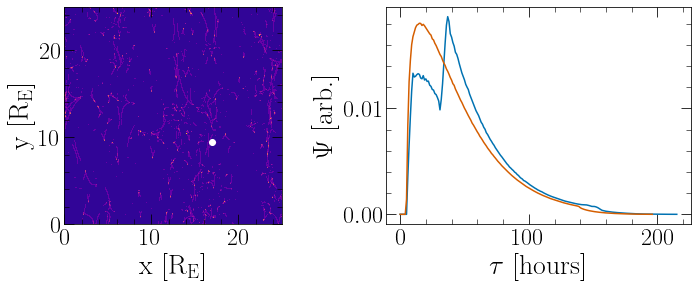

In [22]:
seednum = 12
wavelength=500
cheight=20
np.random.seed(seednum) #Reproducibility between returning maps and transfer function

delays, mag_response, x_po, y_po = MagMap.GenerateMicrolensedResponse(AccretionDisk, 
                                wavelength, coronaheight=cheight, returnmaps=True)
np.random.seed(seednum)
mag_tf = MagMap.GenerateMicrolensedResponse(AccretionDisk, 
                                wavelength, coronaheight=cheight, smooth=True)

x = np.linspace(0, 25, 10000)
y = np.linspace(0, 25, 10000)
X, Y = np.meshgrid(x, y, indexing='ij')

fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].contourf(X, Y, MagMap.mag_map, cmap='plasma')
ax[0].plot(x_po/400, y_po/400, "o", color='white')
ax[0].set_xlabel(r"x [R$_{\rm E}$]")
ax[0].set_ylabel(r"y [R$_{\rm E}$]")
ax[0].set_aspect(1)

ax[1].plot(mag_tf)
ax[1].plot(basic_transfer_function)
ax[1].set_xlabel(r"$\tau$ [hours]")
ax[1].set_ylabel(r"$\Psi$ [arb.]")
plt.show()


Here, the left plot shows the magnification map with a white dot located where the transfer function is calculated at. In right is the response in blue, with the unmicrolensed case in orange. Microlensing may have a significant impact, which is why the seed was set as "12". Normally the impact is not as great as this.

The next couple functions are a few conveinence functions, MakeDRW creates a generic damped random walk signal given parameters:

t_max, the maximum time we calculate to

delta_t, the time step between points

SF_inf, the asymptotic structure function value

tau, the characteristic time scale

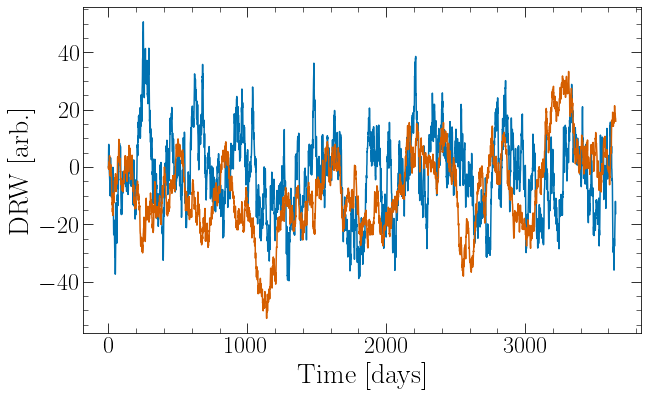

In [23]:
t_max = 10 # years, by default
delta_t = 1 # days, by default
SF_inf = 20
tau = 30 # Days, by default
np.random.seed(3)

DRW = QMF.MakeDRW(t_max, delta_t, SF_inf, tau)
DRW2 = QMF.MakeDRW(t_max, delta_t, SF_inf, tau*4)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DRW)
ax.plot(DRW2)
ax.set_xlabel("Time [days]")
ax.set_ylabel("DRW [arb.]")
plt.show()

The function Correlate takes one to two light curves in.

With one light curve, it will calculate the autocorrelation of the light curve.

With two light curves, the correlation will be computed.

If the light curves are not correlated greater than the noise level, more than two roots may be found and an error will occur. In this case, the function cannot find a correlation.

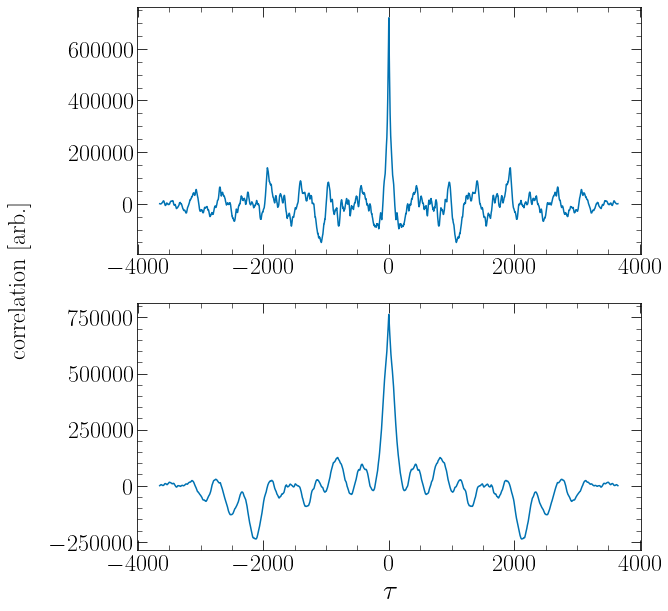

In [24]:
lag1, corr1, fwhm1, peak1 = QMF.Correlate(DRW)
lag2, corr2, fwhm2, peak2 = QMF.Correlate(DRW2)
axis = np.linspace(-len(DRW), len(DRW), len(corr1))

fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(axis, corr1)
ax[1].plot(axis, corr2)
ax[1].set_xlabel(r"$\tau$")
fig.supylabel("correlation [arb.]", fontsize=24)
fig.subplots_adjust(left=0.2)
plt.show()



Let's create a second signal which is really just a shifted section of one signal to show that lags may be determined using this

original signal is 3653 time steps
the new signals are 2600 and 2600 time steps
the overlap between signals is  1547 time steps


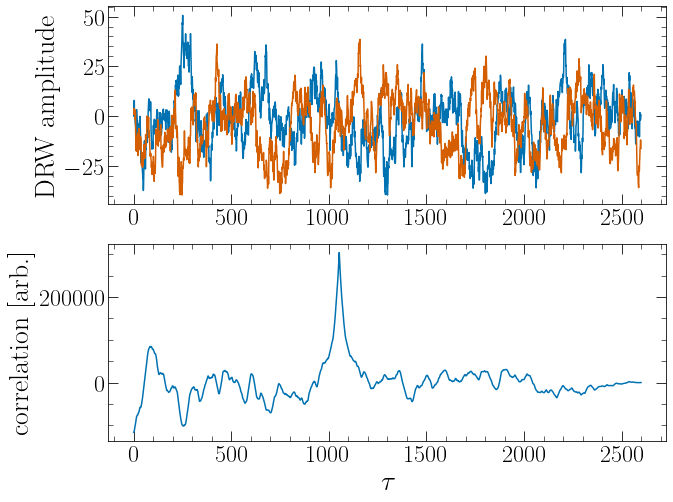

In [25]:
maxindex = 2600
print("original signal is",len(DRW),"time steps")

signal1 = DRW[:maxindex]
signal2 = DRW[-maxindex:]
print("the new signals are", len(signal1), "and", len(signal2),"time steps")
print("the overlap between signals is ", str(max(0, len(DRW) - 2*(len(DRW)-len(signal1)))), "time steps")

lag1, corr1, fwhm1, peak1 = QMF.Correlate(signal1, LightCurve2 = signal2)

times = np.linspace(0, len(corr1)//2, len(corr1)//2+1)

fig, ax = plt.subplots(2, figsize=(10,8))
ax[0].plot(signal1)
ax[0].plot(signal2)
ax[1].plot(times, corr1[len(corr1)//2:])
ax[1].set_xlabel(r"$\tau$")
ax[1].set_ylabel("correlation [arb.]")
ax[0].set_ylabel("DRW amplitude")
plt.show()

We can see that we cut off ~ 1,000 time steps from DRW when we made signals 1 and 2, but correlation could easily find their overlap

The final two functions are convenience functions used within some mapping functions internally. They are used to convert between Cartesian and Polar coordinate systems.

# Now we can go through features of the classes

## Disk

Our ThinDisk object is named simply because it calculates the accretion disk's properties as if it were a flat disk. If Sim5 is installed, a helper function to create all maps through ray tracing around the central black hole is included in QMF, where the outputs may be fed directly into the ThinDisk object.

We will go through the arguments for this helper function:

mass_exp, log_10(M_BH/M_sun)

redshift, source redshift

numGRs, number of gravitational radii to calculate the accretion disk out to RADIALLY

inc_ang, the inclination angle of the disk in degrees

resolution, the amount of pixels used in calculating the images along each axis

spin, the dimensionless spin parameter of the central black hole

disk_acc, the amount of material accreted

temp_beta, the strength of the disk wind (or asymptotic temperature slope if genericbeta is True)

coronaheight, the z position of the irradiating corona in gravitational radii

albedo, the reflectivity of the disk with respect to the x-ray heating source. 0 is perfect absorption, while 1 is perfect reflection (therefore, no contribution)

eta, the x-ray source efficiency coefficient. Determines how strong the illuminating source is with respect to the bolometric luminosity.

genericbeta, a toggle to use if you want temp_beta to represent the asymptotic temperature slope

eddingtons, if given as a fraction, the required accretion rate will be calculated to meet this eddington ratio and used instead of the default value for disk_acc.



Ray tracing may be time consuming, and is known to be the longest part of the simulation process. We therefore defer using this function right now and opt to use a pre-traced file: Sim5ThinDisk8.0Msun0Spin40Inc.fits.

In [26]:
filepath = 'Amoeba/SampleDisks/8.0MsunSample.fits'  #path to fits file
with fits.open(filepath) as f:
    m1 = f[0].data
    m2 = f[1].data
    m3 = f[2].data
    m4 = f[3].data

f[0].header
mexp = f[0].header['mass']
zq = f[0].header['zq']
spin = f[0].header['spin']
inc_ang = f[0].header['inc_ang']
c_height = f[0].header['c_height']
beta = f[0].header['beta']
numGRs = 1000

AccDisk = Amoeba.ThinDisk(mexp, zq, numGRs, inc_ang, c_height, m1, m2, m3, m4, spin=spin)



Now that a proper accretion disk is loaded in memory, we can do things more simply. Let's make the surface intensity map with the method "MakeSurfaceIntensityMap".

We require an argument of the wavelength.

Additionally, toggling returnwavelengths to True will give a map of the locally emitted wavelengths which get shifted into the observers wavelength.

/Users/henrybest/PythonStuff/Code/Amoeba.py:78: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


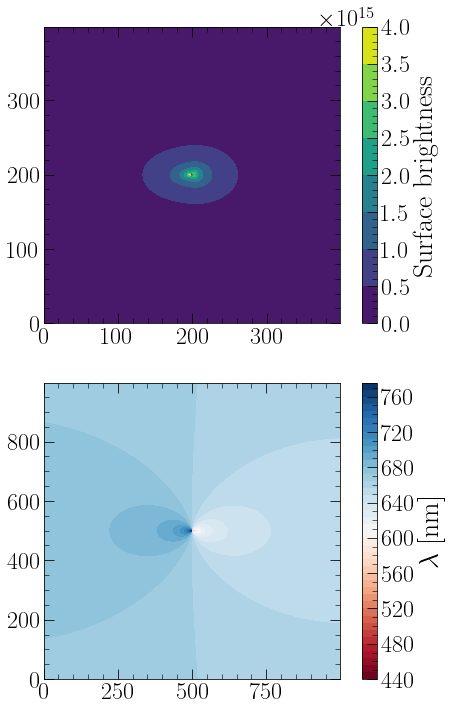

In [27]:
wavelen = 1000
intensities, wavelengths = AccDisk.MakeSurfaceIntensityMap(wavelen, returnwavelengths=True)
size = 200
center=500
fig, ax = plt.subplots(2, figsize=(8,12))
c1 = ax[0].contourf(intensities[center-size:center+size, center-size:center+size])
c2 = ax[1].contourf(wavelengths, 50,cmap='RdBu')
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.colorbar(c1, ax=ax[0], label="Surface brightness")
plt.colorbar(c2, ax=ax[1], label=r"$\lambda$ [nm]")
plt.show()

In the first plot, we have zoomed in to highlight the asymmetry. In the second plot, we show the wavelengths across the disk which get shifted into the observed wavelength.

It is shown that a surface intensity map can be asymmetric especially near the black hole, and the calculated wavelengths are non-trivial across the whole map.

The methods MakeDBDTMap, MakeTimeDelayMap, and MakeDTDLxMap are more straight-forward ways to run the functions that construct the transfer function which we saw earlier. Arguments are fewer, as many are passed in directly from the initialization of the object. Many initialized values can still be overridden.

We can look at ConstructDiskTransferFunction next, which combines the above methods that were just glossed over. Arguments are:

wavelength, the wavelength in the observers frame of reference in nanometers

coronaheight, if a different lamp post is desired, this is the z position of the irradiating source.

axisoffset/angleoffset is the (r, phi) position of this irradiating source

maxlengthoverride, a tool to predetermine the longest time lag you calculae out to

units, the units of the time lag axis on the constructed transfer function

albedo, reflectivity of the accretion disk. 

smooth, toggle to use a smoothing kernel on the transfer function or not

fixedwindowlength, user specified smoothing kernel size, otherwise it will be determined automatically

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


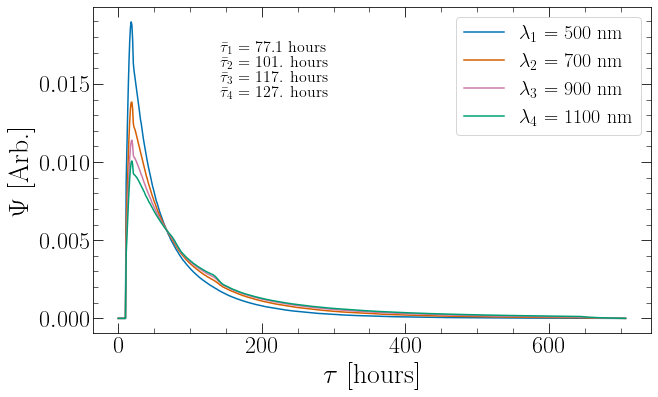

In [28]:
wavelen1 = 500
wavelen2 = 700
wavelen3 = 900
wavelen4 = 1100

transfer_function1 = AccDisk.ConstructDiskTransferFunction(wavelen1)
transfer_function2 = AccDisk.ConstructDiskTransferFunction(wavelen2)
transfer_function3 = AccDisk.ConstructDiskTransferFunction(wavelen3)
transfer_function4 = AccDisk.ConstructDiskTransferFunction(wavelen4)

mean1 = np.sum(np.linspace(0, len(transfer_function1), len(transfer_function1)) * transfer_function1)
mean2 = np.sum(np.linspace(0, len(transfer_function2), len(transfer_function2)) * transfer_function2)
mean3 = np.sum(np.linspace(0, len(transfer_function3), len(transfer_function3)) * transfer_function3)
mean4 = np.sum(np.linspace(0, len(transfer_function4), len(transfer_function4)) * transfer_function4)

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(transfer_function1, label=r"$\lambda_{1}$ = "+str(wavelen1)+" nm")
ax.plot(transfer_function2, label=r"$\lambda_{2}$ = "+str(wavelen2)+" nm")
ax.plot(transfer_function3, label=r"$\lambda_{3}$ = "+str(wavelen3)+" nm")
ax.plot(transfer_function4, label=r"$\lambda_{4}$ = "+str(wavelen4)+" nm")

ax.text(0.2 * len(transfer_function1), 0.9 * np.max(transfer_function1), r"$\bar{\tau}_{1}$ = "+str(mean1)[:4]+" hours", fontsize=16)
ax.text(0.2 * len(transfer_function1), 0.85 * np.max(transfer_function1), r"$\bar{\tau}_{2}$ = "+str(mean2)[:4]+" hours", fontsize=16)
ax.text(0.2 * len(transfer_function1), 0.8 * np.max(transfer_function1), r"$\bar{\tau}_{3}$ = "+str(mean3)[:4]+" hours", fontsize=16)
ax.text(0.2 * len(transfer_function1), 0.75 * np.max(transfer_function1), r"$\bar{\tau}_{4}$ = "+str(mean4)[:4]+" hours", fontsize=16)

ax.legend()
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel(r"$\Psi$ [Arb.]")

plt.show()

We have plotted here the derived transfer functions for four wavelengths, and the mean time delays.

Longer wavelengths will generally have wider transfer functions and therefore longer mean time lags as expected.

## Magnification Map

The MagnificationMap object is used to store and use a magnification map due to microlensing. In creating this object, the following arguments are needed:

redshift_quasar, the redshift of the source

redshift_lens, the redshift of the microlenses (which must be less than the redshift of the source)

file_name, the file which contains the magnification map. This can be a .fits file or a .dat, or a numpy array of values. If downloaded from the GERLUMPH database, it will come as a .dat file, which will be converted into a ray map of appropriate size. It's recommended to store this as a .fits file for future use to speed up the conversion process. Amoeba assumes this file will be ray counts per pixel, so a conversion to magnification will occur next.

convergence, the total convergence of the microlensing map (Kappa)

shear, the shear of the microlensing map (Gamma)

m_lens, the assumed average microlens mass

n_einstein, the number of Einstein radii along each side of the magnification map. A square map is assumed.

Om0, OmL, H0: the cosmological parameters of the flat LambdaCDM model

ismagmap, a toggle to tell Amoeba that the input map is actually an array of magnifications instead of ray counts. This stops the conversion of ray counts to magnification values.

name, a name space


In [29]:
mag_map_path = "Amoeba/SampleMagMap/map.fits"

with fits.open(mag_map_path) as f:
    mag_map = f[0].data

MagMap = Amoeba.MagnificationMap(0.1, 0.05, mag_map, 0.3, 0.3, ismagmap=True)

/Users/henrybest/PythonStuff/Code/Amoeba.py:156: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if file_name[-4:] == 'fits':
/Users/henrybest/PythonStuff/Code/Amoeba.py:159: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif file_name[-4:] == '.dat':


10000
0.004938182452918769
506.25913964
50625913964.0


The magnification map of the MagnificationMap object can be referenced directly by MagnificationMap.mag_map

The pixel size is stored as MagnificationMap.px_size



One primary method used will be Convolve, which calculates the convolution of an accretion disk with the magnification map. It takes the following arguments:

Disk, the accretion disk object

obs_wavelength, the observed wavelength. This value gets redshifted to the local wavelength at the source plane, then the surface brightness map is calculated for that wavelength (which further considers Doppler shifting and gravitational redshift).

rotation, a degree rotation in the source plane

This convolution can be stored in the object ConvolvedMap, to facilitate creating microlensing light curves

In [30]:
filepath = 'Amoeba/SampleDisks/8.0MsunSample.fits'  #path to fits file
with fits.open(filepath) as f:
    m1 = f[0].data
    m2 = f[1].data
    m3 = f[2].data
    m4 = f[3].data

f[0].header
mexp = f[0].header['mass']
zq = f[0].header['zq']
spin = f[0].header['spin']
inc_ang = f[0].header['inc_ang']
c_height = f[0].header['c_height']
beta = f[0].header['beta']
numGRs = 1000

AccDisk = Amoeba.ThinDisk(mexp, zq, numGRs, inc_ang, c_height, m1, m2, m3, m4, spin=spin)

/Users/henrybest/PythonStuff/Code/Amoeba.py:78: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


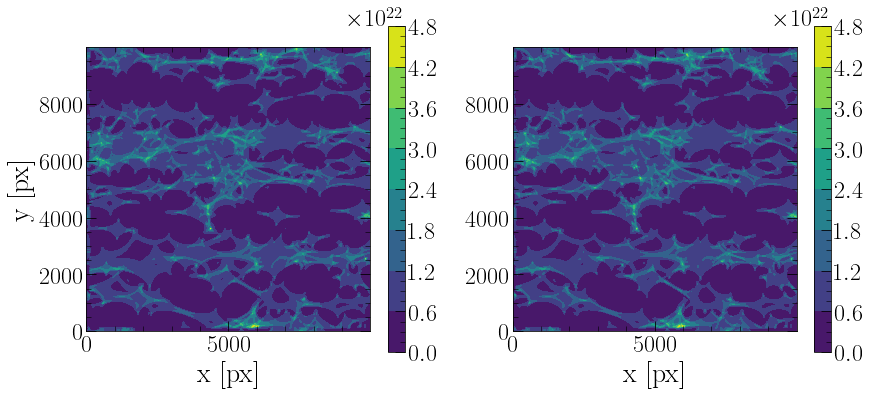

In [31]:
convolution, px_size, px_shift = MagMap.Convolve(AccDisk, 500)
Conv_Map = Amoeba.ConvolvedMap(MagMap, AccDisk, 500)

fig, ax = plt.subplots(1,2, figsize=(14,6))

contours1 = ax[0].contourf(convolution)
contours2 = ax[1].contourf(Conv_Map.mag_map)
plt.colorbar(contours1, ax=ax[0])
plt.colorbar(contours2, ax=ax[1])
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[0].set_xlabel(r"x [px]")
ax[1].set_xlabel(r"x [px]")
ax[0].set_ylabel(r"y [px]")
plt.show()

There is no notable difference between the two, however the pixel shift is stored within the ConvolvedMap. This value is inportant for accurately pulling light curves!

In [32]:
print(MagMap.px_shift)
print(px_shift)
print(Conv_Map.px_shift)

0
122
122


However, this also means the convolved map is now locked at a certain observed wavelength. 

ConvolvedMap is a child of MagnificationMap, so it has the PullValue and PullLightCurve methods.

PullValue is generally not useful by itself, but PullLightCurve uses this method to extract the light curve. It has the following arguments:

vtrans, the transverse velocity in the source plane. This is expressed as km/s, where typical values range up to ~500 km/s. Some special cases like the Einstein Cross (Q2237+0305) may have significantly higher transverse velocities.

time, the length of the light curve measured in years

x_start, y_start: the starting position of the light curve in pixels. If left as None, a random starting point will be selected such that it will not cross into the convolution artifacts found near the edges.

phi_angle, the direction of travel in the source plane measured in degrees

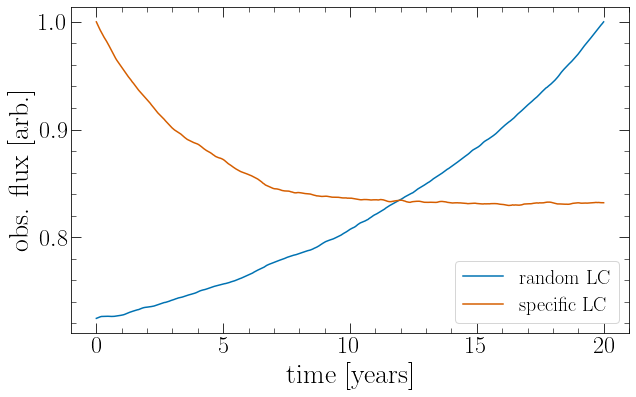

In [33]:
x = 4000   # pixels
y = 7000   # pixels
phi = 72   # degrees
vel = 400  # km/s
time = 20  # years

np.random.seed(21)

LC_specified = Conv_Map.PullLightCurve(vel, time, x_start=x, y_start=y, phi_angle=phi)
LC_random = Conv_Map.PullLightCurve(vel, time)

fig, ax = plt.subplots(figsize=(10, 6))
timeaxis = np.linspace(0, time, len(LC_random))
ax.plot(timeaxis, LC_random/np.max(LC_random), label='random LC')
ax.plot(timeaxis, LC_specified/np.max(LC_specified), label='specific LC')
ax.set_xlabel("time [years]")
ax.set_ylabel("obs. flux [arb.]")
ax.legend()
plt.show()

There are units involved in extracting these light curves, but the scaling depends on the size of the instrument used and the total size of the accretion disk image. It is safe to normalize them to use arbitrarily in studies.

The final method in the MagnificationMap object is GenerateMicrolensedResponse, which should be called with the MagnificationMap object only and not the ConvolvedMap (else there will be a double convolution). This method computes a microlensed transfer function using the QMF function MicrolensedResponse as was done previously.

The GenerateMicrolensedResponse takes the following arguments:

Disk, the accretion disk object

wavelength, the observed wavelength

coronaheight, the z position of the flaring lamp post which the transfer function will be constructed with respect to. If left "None", this will keep the lamp post position of the accretion disk object. Modeling other sources of irradiation can be done as well.

rotation, the degree rotation on the source plane. This is sometimes refered to as the position angle on the microlensing map.

x_position, y_position: the (x, y) coordinates in pixels on the magnification map. If left "None", this will randomly choose a spot which will remain fully on the magnification map, if possible.

axisoffset, angleoffset: the (r, phi) position of the flaring lamp post with respect to the accretion disk's axis of symmetry, in units $R_{\rm g}$ and degrees.

unit, the time units of the transfer function

smooth, toggle to use a smoothing kernel on the transfer function after it's calculated

returnmaps, toggle to return the maps prior to calculating the transfer function

/Users/henrybest/PythonStuff/Code/Amoeba.py:94: RuntimeWarning: invalid value encountered in sqrt
  gravshiftfactor = (1 - event_horizon/radius)**0.5


0.4893745324890984 311190786872.26654 635894935703.8698
0.4893745324890984 311190786872.26654 635894935703.8698


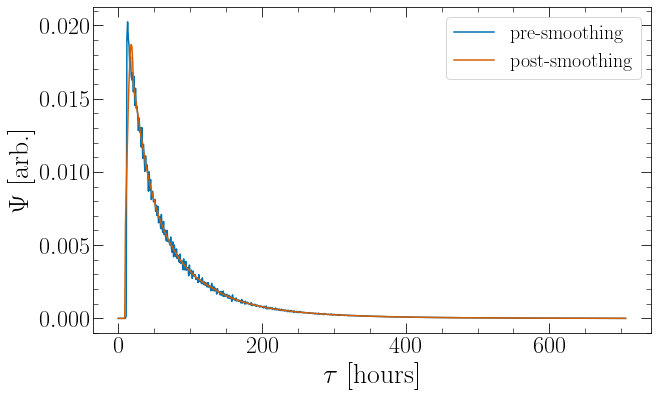

In [34]:
wavelength = 500
seednum = 40
np.random.seed(seednum)
TransferFunction = MagMap.GenerateMicrolensedResponse(AccDisk, wavelength)
np.random.seed(seednum)
TransferFunctionSmooth = MagMap.GenerateMicrolensedResponse(AccDisk, wavelength, smooth=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(TransferFunction, label="pre-smoothing")
ax.plot(TransferFunctionSmooth, label='post-smoothing')
ax.set_xlabel(r"$\tau$ [hours]")
ax.set_ylabel(r"$\Psi$ [arb.]")
ax.legend()
plt.show()

Due to the finite size of the smoothing kernel and the abrupt start of the transfer function, it may appear to shift the peak very slightly. However, we can show this only has a minor effect on the mean value of $\tau$.

In [35]:
meanTF = np.sum(np.linspace(0, len(TransferFunction), len(TransferFunction))*TransferFunction)
meansmoothTF = np.sum(np.linspace(0, len(TransferFunctionSmooth), len(TransferFunctionSmooth))*TransferFunctionSmooth)

print(r"Without smoothing, tau_avg = "+str(meanTF)[:5]+" hours")
print(r"With smoothing, tau_avg = "+str(meansmoothTF)[:5]+" hours")

Without smoothing, tau_avg = 76.67 hours
With smoothing, tau_avg = 76.93 hours


This notebook will be extended as features are added, thank you for taking the time to try Amoeba out!